# Part 1 - Test main functions and train classifier

### Let's play around with all functions before get into the stream pipeline

In [1]:
# Import and export
import pickle
import glob

# Computer vision
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog

## Load test images

In [2]:
images = glob.glob('test_images/*.jpg')

In [3]:
images

['test_images/test6.jpg',
 'test_images/test1.jpg',
 'test_images/test5.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/test4.jpg',
 'test_images/straight_lines1.jpg',
 'test_images/test3.jpg']

In [4]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

## Manual vehicle detection
### Here we create a function to manually draw boxes in an image

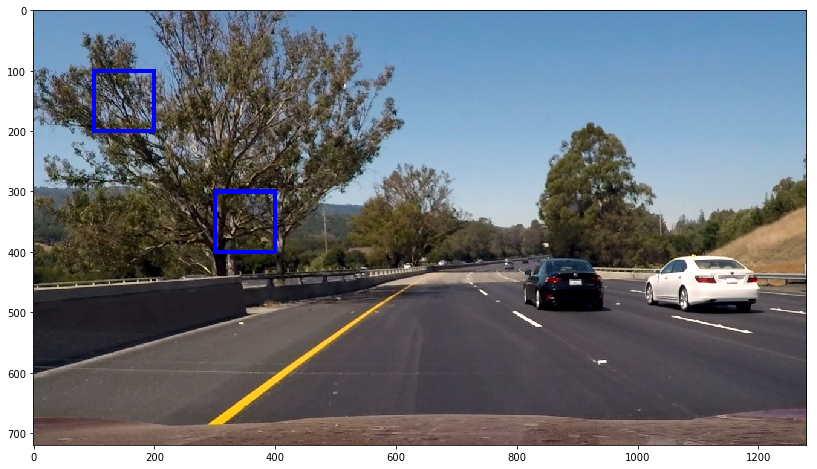

In [5]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    img: (M, N, H) ndarray
    bboxes: bounding box positions, [((x1, y1), (x2, y2)), ((,),(,)), ...]
    color: optional 3-tuple, for example, (0, 0, 255) for blue
    thick: optional integer parameter to define the box thickness
    '''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Test it
# Load image
image = cv2.imread(images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Define some boxes
bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
# Drawing box
result = draw_boxes(image, bboxes)
# Visualize it
plt.imshow(result)

## Color Histogram Features

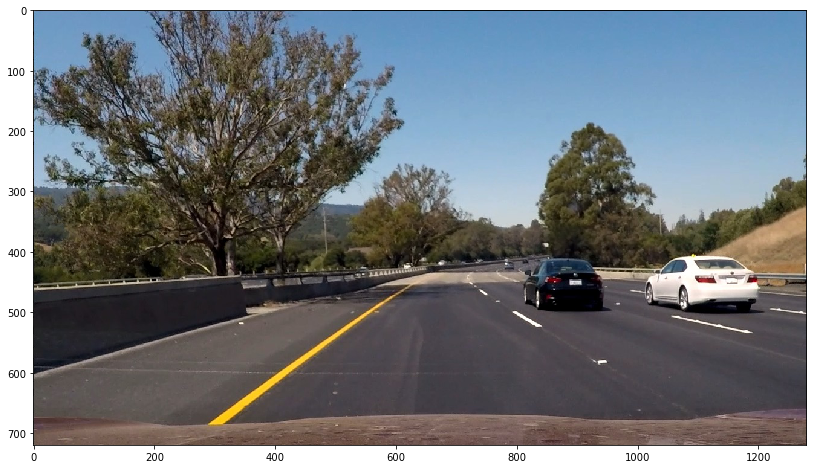

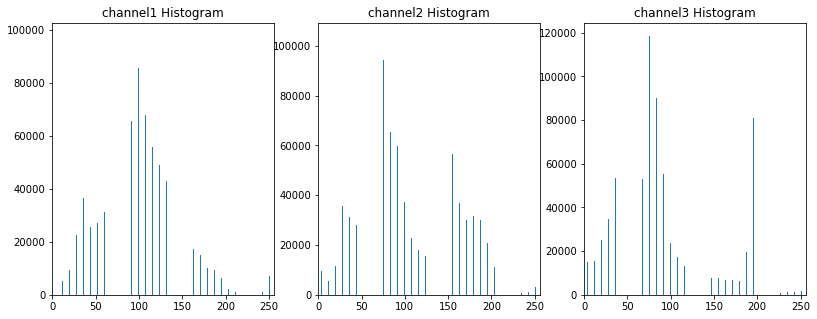

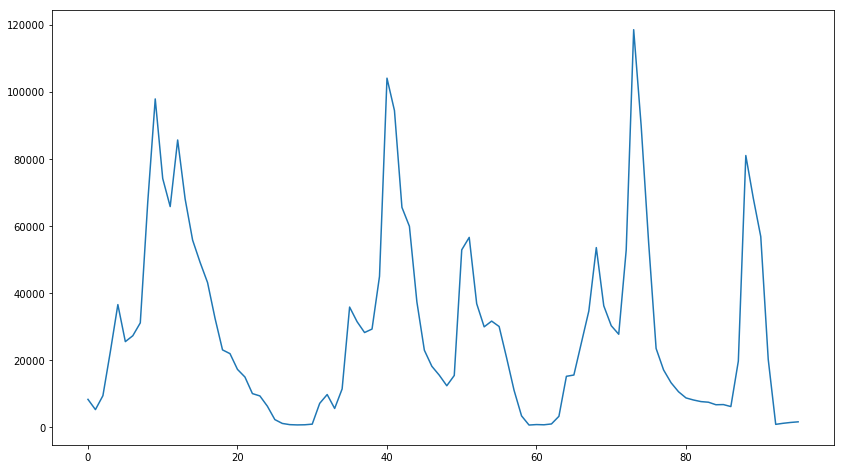

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, plot=False):
    '''
    img: (M, N, H) ndarray
    
    nbins: optional, bins is an int, it defines the number of equal-width bins in the given range
    
    
    plot: optional plot of the image color features
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if plot:
        # Generating bin centers
        # Each of the histograms in this case have the same bins, so I'll just use the rhist bin edges
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Plot it
        fig = plt.figure(figsize=(13.5,5))
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title('channel1 Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title('channel2 Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title('channel3 Histogram')
        plt.show()
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Test it
# Load image
image = cv2.imread(images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.show()
# Color Features
result = color_hist(image, nbins=32, plot=True)
plt.plot(result)

## Spatial Binning of Color
### Downscale image size to improve pipeline performance

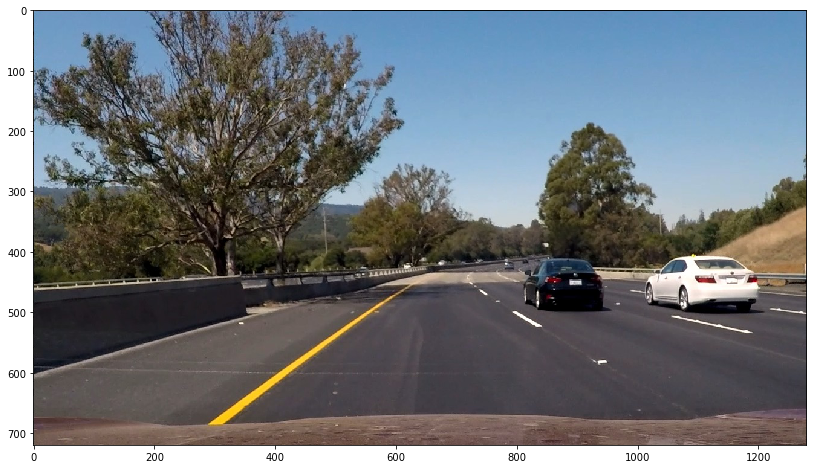

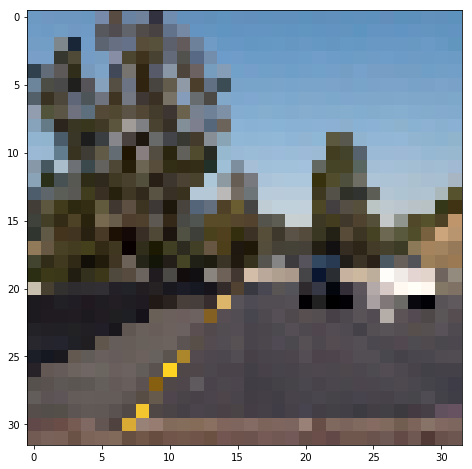

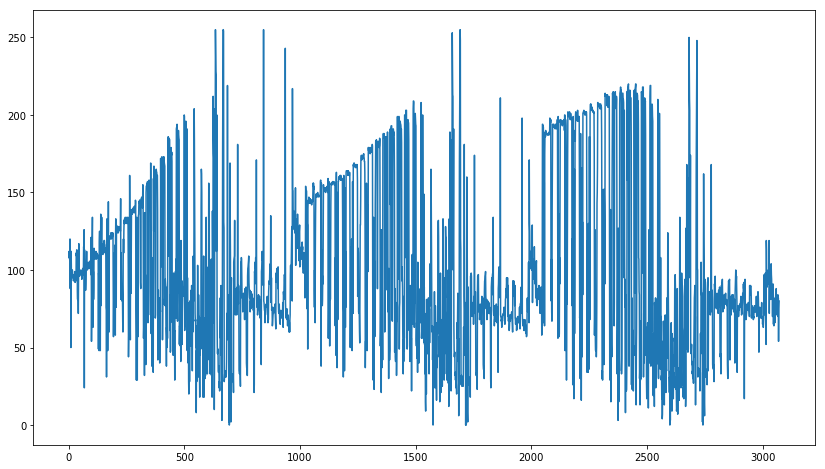

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32), plot=False):
    '''
    img: (M, N, H) ndarray
    
    size: optional 2-tuple, output image size
    
    plot: optional plot of the spatial binning
    '''
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()

    if plot:
        temp_result = cv2.resize(img, size)
        plt.imshow(temp_result)
        plt.show()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Test it
# Load image
image = cv2.imread(images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.show()
# Spacial binning
result = bin_spatial(image, size=(32, 32), plot=True)
plt.plot(result)

## HOG (Histogram of Oriented Gradient) Features

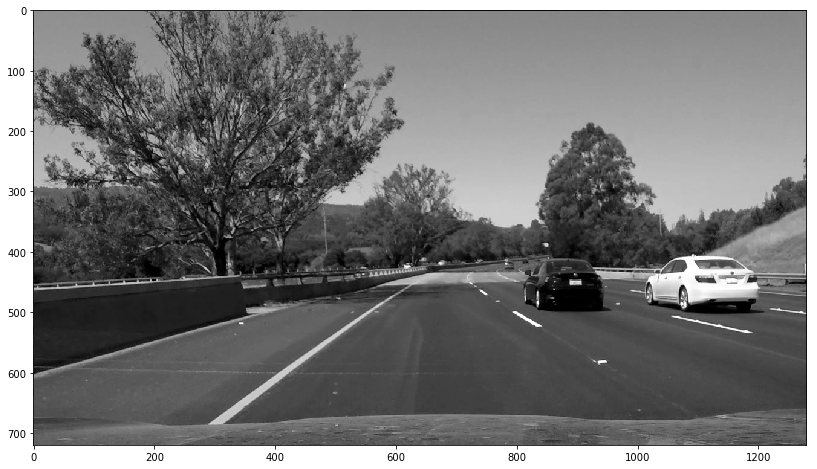

/media/ricardo/MyFiles/anaconda3/envs/carnd-t1-36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


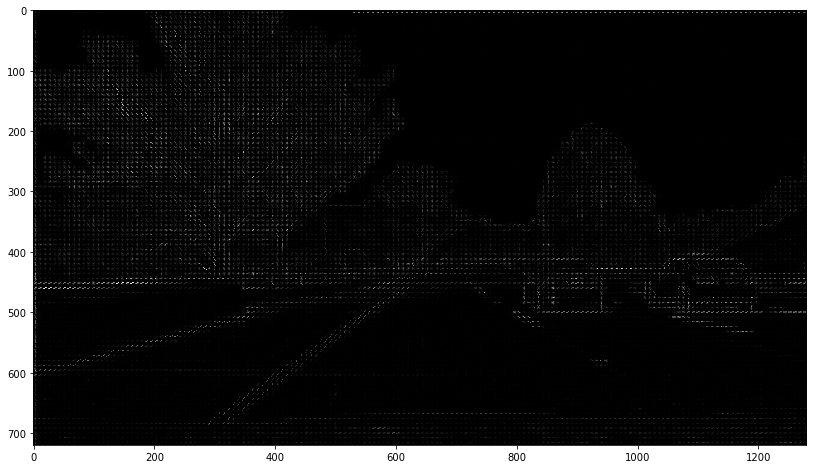

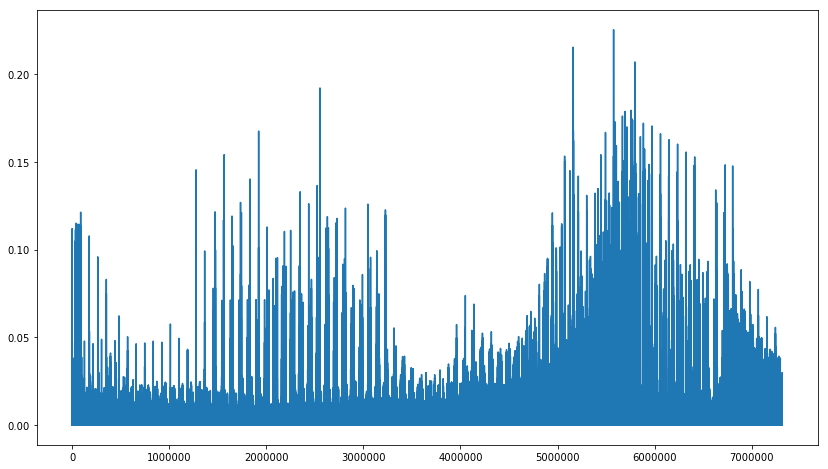

In [8]:
# Define a function to return HOG (Histogram of Oriented Gradient) features and visualization
def get_hog_features(img, orient=9, pix_per_cell=(8,8), cell_per_block=(8,8), 
                        vis=False, feature_vec=True, plot=False):
    '''
    img: (M, N) ndarray,  single color channel or grayscaled image
    
    orient: optional, integer, and represents the number of orientation bins that the gradient information
            will be split up into in the histogram. Typical values are between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, cell size over which each gradient histogram is computed. This paramater
                  is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are
                  commonly chosen to be square
                   
    cell_per_block: optional 2-tuple, and specifies the local area over which the histogram counts in a given
                    cell will be normalized. Block normalization is not necessarily required, but generally
                    leads to a more robust feature set
                    
    vis: flag tells the function to output a visualization of the HOG feature computation or not
    
    feature_vec: flag tells the function to unroll the feature array into a feature vector using same as
                 features.ravel() would do, which yields, in this case, to a one dimensional array
    
    plot: optional plot of the featured HOG
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=pix_per_cell,
                                  cells_per_block=cell_per_block, 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        if plot:
            plt.imshow(hog_image, cmap='gray')
            plt.show()
        return features, hog_image
    # Otherwise call with one output
    else:         
        if plot:
            features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=pix_per_cell,
                                  cells_per_block=cell_per_block, 
                                  transform_sqrt=True, 
                                  visualise=True, feature_vector=feature_vec)
            plt.imshow(hog_image, cmap='gray')
            plt.show()
        else:
            features = hog(img, orientations=orient, 
                       pixels_per_cell=pix_per_cell,
                       cells_per_block=cell_per_block, 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
            
        return features

# Test it
# Load image
image = cv2.imread(images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray') 
plt.show()
# Spacial binning
orient = 9
pix_per_cell = (8,8)
cell_per_block = (8,8)
result = get_hog_features(gray_image, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, plot=True)
plt.plot(result)

## Combine and Normalize Features
### Combine color and HOG features, normalize it

['test_images/test6.jpg']


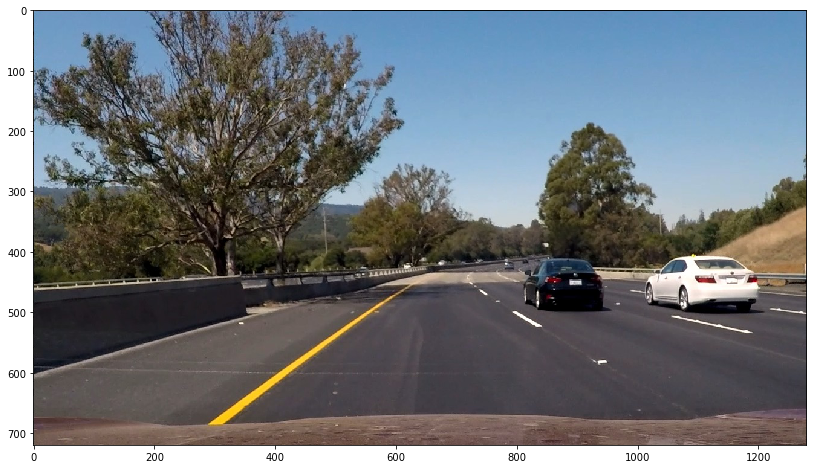

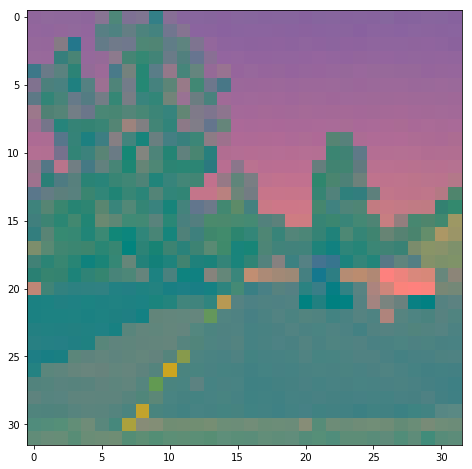

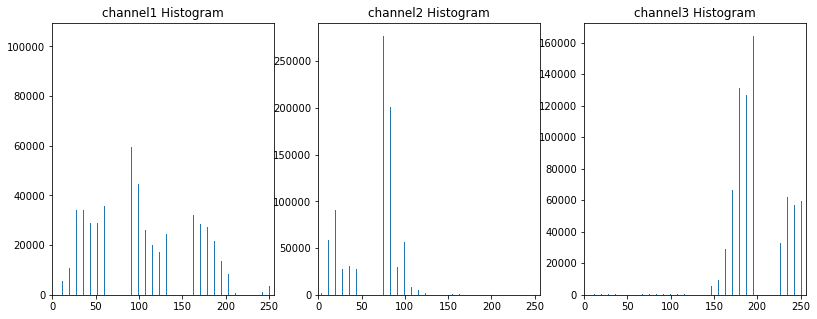

/media/ricardo/MyFiles/anaconda3/envs/carnd-t1-36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


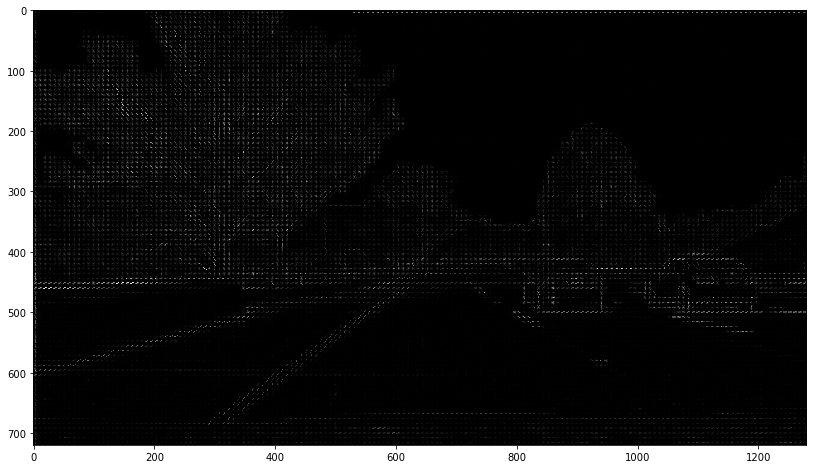

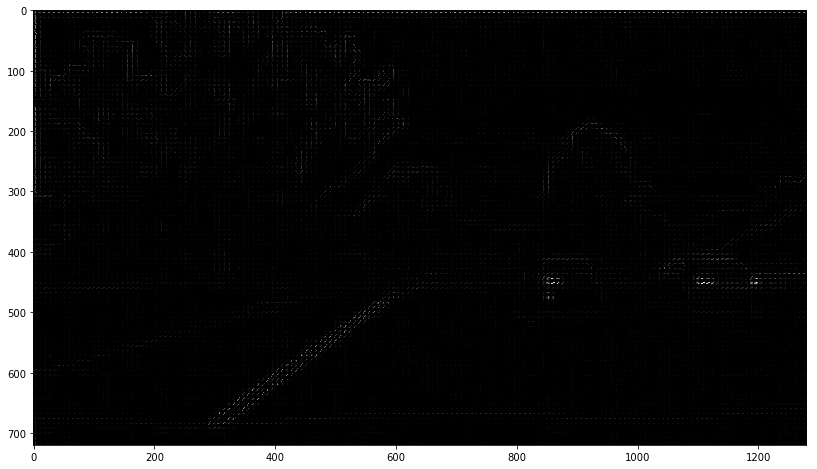

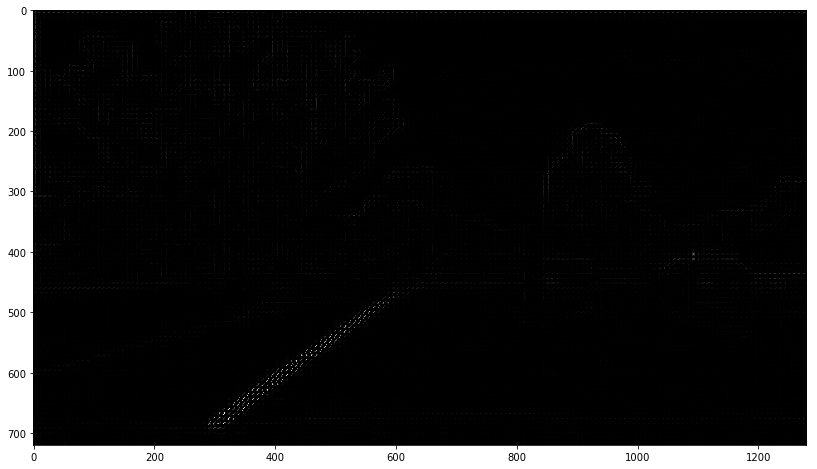

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', hist_bins=32,
                     spatial_size=(32, 32),
                     orient=9, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0,
                     hist_feat=True, spatial_feat=True, hog_feat=True,
                     plot=False):
    '''
    imgs:  list of image filenames
    
    color_space: optional for color feature extraction,'RGB', 'HSV', 'LUV', 'HLS', 'YUV' or 'YCrCb' 
    
    hist_bins: optional for color feature extraction, bins is an int, it defines the number of
               equal-width bins in the given range
               
    spatial_size: optional for spatial bining, 2-tuple, spatial binning output image size
    
    orient: optional for HOG feature extraction, integer, and represents the number of orientation bins
            that the gradient information will be split up into in the histogram. Typical values are
            between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, for HOG feature extraction, cell size over which each gradient histogram is computed.
                  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y,
                  but cells are commonly chosen to be square
                  
    cell_per_block: optional 2-tuple, for HOG feature extraction, specifies the local area over which the
                    histogram counts in a given cell will be normalized. Block normalization is not 
                    necessarily required, but generally leads to a more robust feature set
                    
    hog_channel: optional for HOG feature extraction, which channel t apply HOG: 0, 1, 2 or "ALL"
    
    hist_feat: flag to apply or not color histogram feature extraction
    
    spatial_feat: flag to apply or not spatial binning
    
    hog_feat: flag to apply or not HOG feature extraction
    
    plot: optional to plot feature extractions
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.max())
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size, plot=plot)
            #print('len spatial_features in extract_features',len(spatial_features))
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, plot=plot)
            #print('len hist_features in extract_features',len(hist_features))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True, plot=plot))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True, plot=plot)
                #print('len hog_features in extract_features',len(hog_features))
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Test it
print(images[:1])
# Load image
image = cv2.imread(images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.show()
# Feature Extraction
result = extract_features(images[:1], color_space='YCrCb', hist_bins=32,
                     spatial_size=(32, 32),
                     orient=9, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel="ALL",
                     hist_feat=True, spatial_feat=True, hog_feat=True,
                     plot=True)


## Search and Classify

In [10]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Load training data

In [11]:
cars = glob.glob('training_dataset/vehicles/**/*.png')
notcars = glob.glob('training_dataset/non-vehicles/**/*.png')

### Explore the training data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


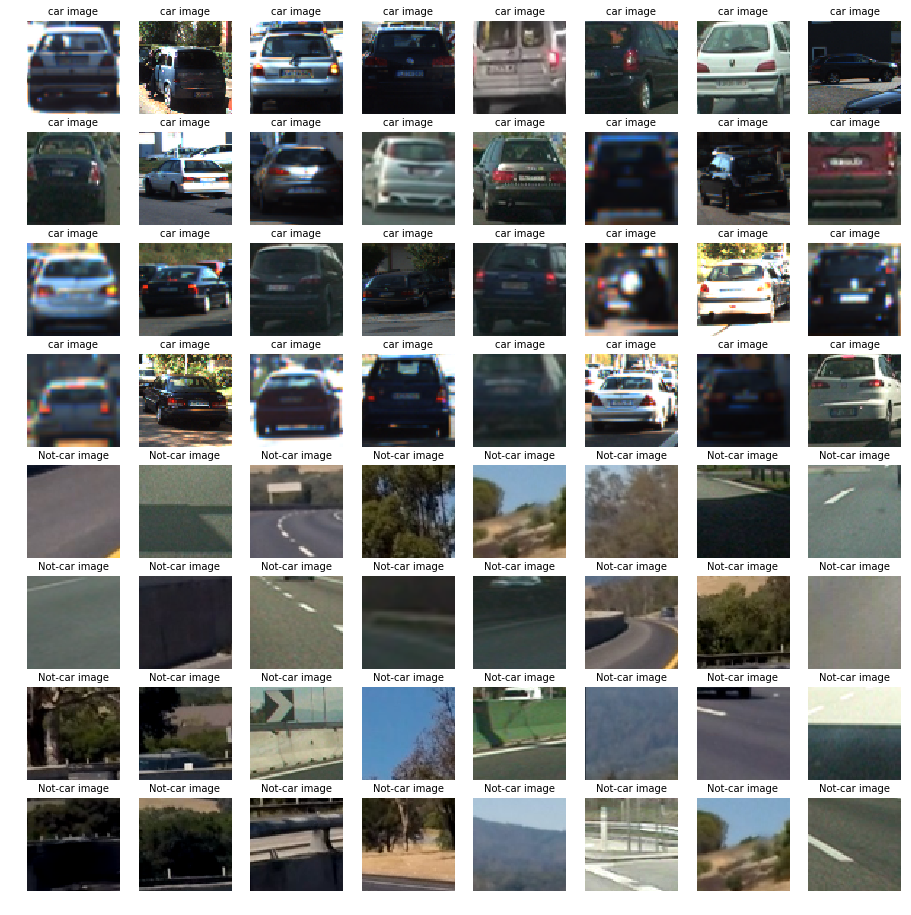

In [12]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    '''
    car_list: list of image filenames
    notcar_list: list of image filenames
    '''
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


# Visualize it
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car image', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not-car image', fontsize=10)
    axs[i].imshow(img)

### Training the classifier

In [13]:
# Reduce the sample size to define best parameters
sample_size = 500
def random_ints(num, lower=0, upper=9):
    import random
    return [random.randrange(lower,upper+1) for i in range(num)] 
rand_idx_ls = random_ints(sample_size, lower=0, upper=len(cars))
cars_reduced = [cars[i] for i in rand_idx_ls]
notcars_reduced = [notcars[i] for i in rand_idx_ls]

In [22]:
# Parameter tunning
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = (8,8) # HOG pixels per cell
cell_per_block = (2,2) # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        hist_bins=hist_bins, spatial_size=spatial_size, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        hist_bins=hist_bins, spatial_size=spatial_size, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, 
                        spatial_feat=spatial_feat, hog_feat=hog_feat)



/media/ricardo/MyFiles/anaconda3/envs/carnd-t1-36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [23]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations (8, 8) pixels per cell and (2, 2) cells per block
Feature vector length: 4932
11.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


In [24]:
# HOG Features during training
# which must be same size later for predictions
window_pixel_x = 64 # size of image used for training
window_pixel_y = 64 # size of image used for training
n_cell_per_window_x = int(window_pixel_x/pix_per_cell[0])
n_cell_per_window_y = int(window_pixel_y/pix_per_cell[1])
n_blocks_position_per_window_x = n_cell_per_window_x - (cell_per_block[0]-1)
n_blocks_position_per_window_y = n_cell_per_window_y - (cell_per_block[1]-1)


features_1_channel = n_blocks_position_per_window_x * n_blocks_position_per_window_y * cell_per_block[0] \
                        * cell_per_block[1] * orient

print('Features 1 channel',features_1_channel)
print('n block position per window x',n_blocks_position_per_window_x)
print('n block position per window y',n_blocks_position_per_window_y)
print('n cells per block x',cell_per_block[0])
print('n cells per block y',cell_per_block[1])
print('n orientations per cell',orient)
print()
print('n cells per window x',n_cell_per_window_x)
print('n cells per window y',n_cell_per_window_y)
print('pixel per cell x', pix_per_cell[0])
print('pixel per cell y', pix_per_cell[1])
print('window pixels x', window_pixel_x)
print('window pixels y', window_pixel_y)

Features 1 channel 1764
n block position per window x 7
n block position per window y 7
n cells per block x 2
n cells per block y 2
n orientations per cell 9

n cells per window x 8
n cells per window y 8
pixel per cell x 8
pixel per cell y 8
window pixels x 64
window pixels y 64


### Checkpoint - Save Training Data

In [37]:
# Save the trained classifier for later use
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

dist_pickle["color_space"] = color_space
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat
dist_pickle["y_start_stop"] = y_start_stop

pickle.dump( dist_pickle, open( "training_dataset/trained_dist_pickle.p", "wb" ) )


### Loading trained data

In [14]:
# Read in the saved trained data
dist_pickle = pickle.load( open( "training_dataset/trained_dist_pickle.p", "rb" ) )

svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]
y_start_stop = dist_pickle["y_start_stop"]

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    '''
    img: (M, N, H) ndarray
    conv: 'RGB2YCrCb', 'RGB2LUV', 'RGB2HSV', 'RGB2HLS' or 'RGB2YUV'
    '''
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size,
              hist_bins,
              window):
    '''
    img: (M, N, H) ndarray
    
    ystart: y pixel coordinate at top of ROI
    
    ystop: y pixel coordinate at bottom of ROI
    
    scale: this scale factor will divide the ROI dimensions. Use >=1, where >1 will decreased dimensions
    
    svc: support vector classifier, example: LinearSVC
    
    X_scaler: normalized feature vectors
    
    orient: integer, and represents the number of orientation bins
            that the gradient information will be split up into in the histogram. Typical values are
            between 6 and 12 bins
            
    pix_per_cell: 2-tuple, cell size over which each gradient histogram is computed.
                  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y,
                  but cells are commonly chosen to be square
                  
    cell_per_block: 2-tuple, specifies the local area over which the
                    histogram counts in a given cell will be normalized. Block normalization is not 
                    necessarily required, but generally leads to a more robust feature set 
    
    spatial_size: for spatial bining, 2-tuple, spatial binning output image size
    
    hist_bins: for color feature extraction, bins is an int, it defines the number of
               equal-width bins in the given range
               
    window: 2-tuple, window searching size
    '''
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
   
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell[0])-1
    nyblocks = (ch1.shape[0] // pix_per_cell[1])-1 
    nfeat_per_block = orient*cell_per_block[0]*cell_per_block[1]
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = (64,64)
    window = window
    nxblocks_per_window = (window[0] // pix_per_cell[0])-1 
    nyblocks_per_window = (window[1] // pix_per_cell[1])-1 
    cells_per_step = (2,2)  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nxblocks_per_window) // cells_per_step[0]
    nysteps = (nyblocks - nyblocks_per_window) // cells_per_step[1]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print('ch1 shape:', ch1.shape)
    #print('hog1 shape:', hog1.shape)
    
    # Initialize a list to append window positions to
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step[1]
            xpos = xb*cells_per_step[0]
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = np.copy(hog_feat1)

            xleft = xpos*pix_per_cell[0]
            ytop = ypos*pix_per_cell[1]     

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window[1], xleft:xleft+window[0]], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            '''
            if (xb==0) and (yb==0):
                print('hog_features shape:', hog_features.shape)
                print('spatial_features shape:', spatial_features.shape)
                print('hist_features shape:', hist_features.shape)
                
                print('ch1.shape[1]',ch1.shape[1])
                print('ch1.shape[0]',ch1.shape[0])
                print('nxblocks',nxblocks)
                print('nyblocks',nyblocks)
                print('nfeat_per_block',nfeat_per_block)
                print('nxblocks_per_window',nxblocks_per_window)
                print('nyblocks_per_window',nyblocks_per_window)
                print('nxsteps',nxsteps)
                print('nysteps',nysteps)
                '''

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1) )           
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_drawx = np.int(window[0]*scale)
                win_drawy = np.int(window[1]*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_drawx,ytop_draw+win_drawy+ystart),(0,0,255),6) 
                
                # Calculate window position
                startx = xbox_left
                endx = startx + win_drawx
                starty = ytop_draw + ystart
                endy = starty + win_drawy

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
                
    return draw_img, window_list  


In [17]:
# HOG Features size must be same as training
# we can change window size but we need to adjust the pixels_per_cell accordingly
window_pixel_x = 72 # size of image used for training
window_pixel_y = 72 # size of image used for training
pix_per_cell = (9,9)
n_cell_per_window_x = int(window_pixel_x/pix_per_cell[0])
n_cell_per_window_y = int(window_pixel_y/pix_per_cell[1])
n_blocks_position_per_window_x = n_cell_per_window_x - (cell_per_block[0]-1)
n_blocks_position_per_window_y = n_cell_per_window_y - (cell_per_block[1]-1)


features_1_channel = n_blocks_position_per_window_x * n_blocks_position_per_window_y * cell_per_block[0] \
                        * cell_per_block[1] * orient

print('Features 1 channel',features_1_channel)
print('n block position per window x',n_blocks_position_per_window_x)
print('n block position per window y',n_blocks_position_per_window_y)
print('n cells per block x',cell_per_block[0])
print('n cells per block y',cell_per_block[1])
print('n orientations per cell',orient)
print()
print('n cells per window x',n_cell_per_window_x)
print('n cells per window y',n_cell_per_window_y)
print('pixel per cell x', pix_per_cell[0])
print('pixel per cell y', pix_per_cell[1])
print('window pixels x', window_pixel_x)
print('window pixels y', window_pixel_y)

Features 1 channel 1764
n block position per window x 7
n block position per window y 7
n cells per block x 2
n cells per block y 2
n orientations per cell 9

n cells per window x 8
n cells per window y 8
pixel per cell x 9
pixel per cell y 9
window pixels x 72
window pixels y 72


/media/ricardo/MyFiles/anaconda3/envs/carnd-t1-36/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


orient 9
pix_per_cell (8, 8)
cell_per_block (2, 2)
spatial_size (32, 32)


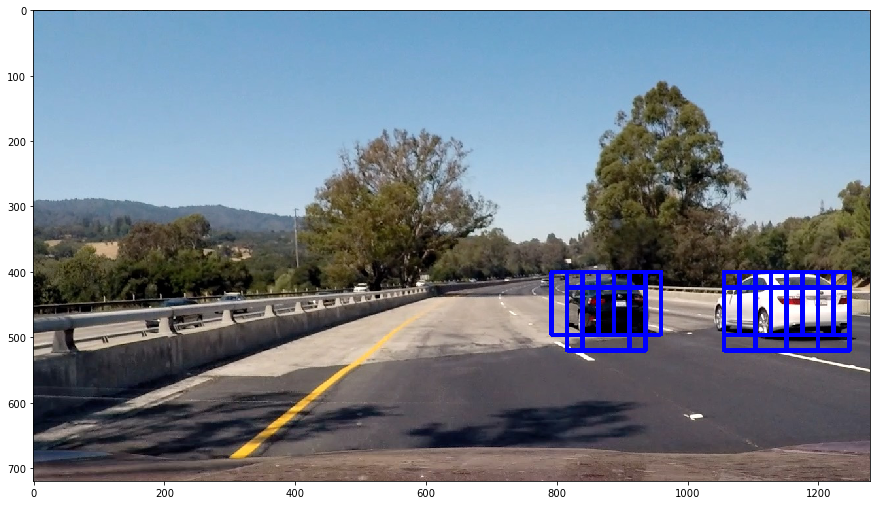

In [132]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "15, 12" # or  whatever you want

ystart = 400
ystop = 656
scale = 1.5

# Load image
image = cv2.imread(images[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pix_per_cell=(8,8)
window = (64,64)

out_img, window_list = find_cars(image, ystart, ystop, scale, svc, X_scaler,
                       orient, pix_per_cell, cell_per_block,
                       spatial_size,
                       hist_bins,
                       window)


print('orient',orient)
print('pix_per_cell',pix_per_cell)
print('cell_per_block',cell_per_block)
print('spatial_size',spatial_size)

plt.imshow(out_img)


### Take car of false positives with heatmaps

2 cars found


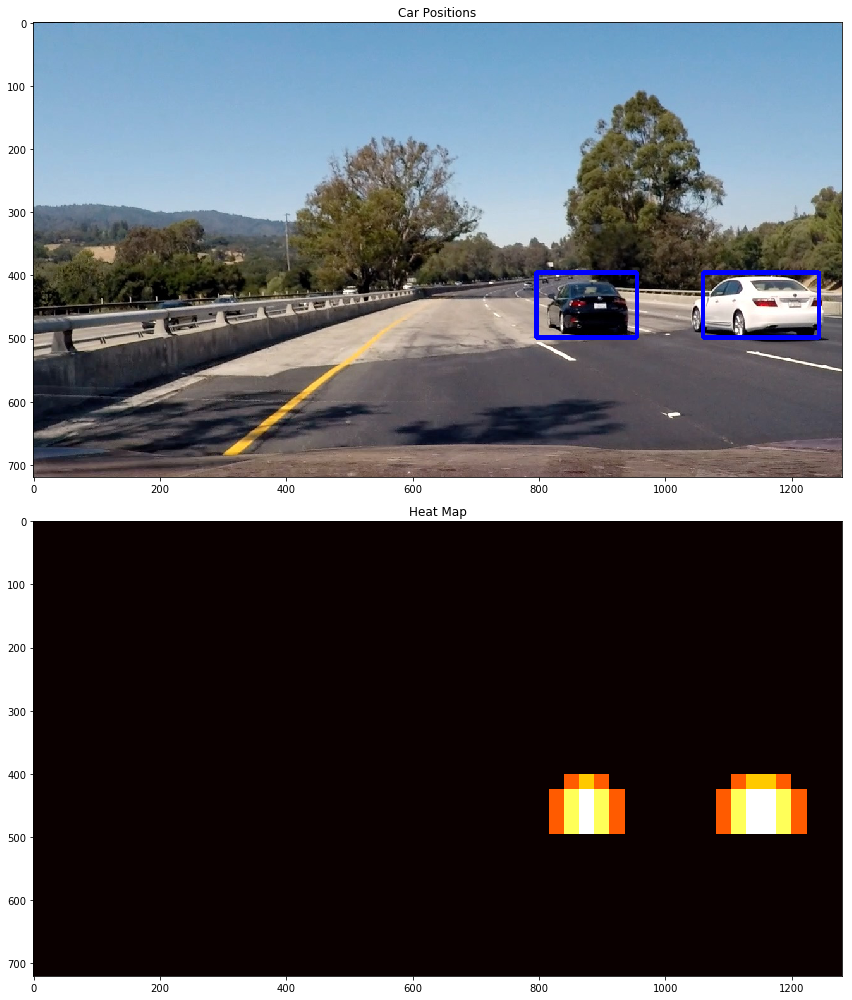

In [129]:
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    '''
    heatmap: mask (1 channel) of original image
    bbox_list: bounding box positions, [((x1, y1), (x2, y2)), ((,),(,)), ...]
    '''
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


    
def apply_threshold(heatmap, threshold):
    '''
    heatmap: mask (1 channel) of original image
    threshold: reject areas affected by false positives
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    '''
    img: (M, N, H) ndarray
    labels: 2-tuple, where the first item is an array the size of the heatmap input image,
            and the second element is the number of labels (cars) found
    '''
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        f1 = 0.00003
        f2 = 0.00013
        #f1 = 0
        #f2 = 0
        z1 = int(f1*np.min(nonzeroy)**2)
        z2 = int(f2*np.min(nonzeroy)**2)
        bbox = ((np.min(nonzerox)-z2, np.min(nonzeroy)-z1), (np.max(nonzerox)+z2, np.max(nonzeroy)+z1))
        #bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# list of boxes for the test image shown above
box_list = window_list

# Create mask heat image 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')

draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure( figsize=(14,14))
plt.subplot(211)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(212)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

